# constants

In [2]:
num_layers = 4
d_model = 300
dff = 512
num_heads = 8
dropout_rate = 0.1

# import

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
import spacy
import pickle
from collections.abc import Iterable
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.config.run_functions_eagerly(False)


# Preprocessing

In [4]:
nlp = spacy.load("en_core_web_md")

In [5]:
def flatten_list(ls: Iterable):
    return [item for sublist in ls for item in sublist]

In [ ]:
# !"#$%&()*+,-./:;<=>?@[\]^_`{|}~
dt = pd.read_csv(r"dataset_raw.csv")
p1t, p1v, p2t, p2v, a1, a2, cond = [], [], [], [], [], [], []
now_id = -1
for i, v in dt.iterrows():
    print(i)
    if now_id != v["id"]:
        now_id = v["id"]
        p1_nlped = nlp(v["q"][1:-1])
        p2_nlped = nlp(v["r"][1:-1])
        p1t.append(flatten_list((token.text for token in sent) for sent in p1_nlped.sents))
        p1v.append(flatten_list((token.vector for token in sent) for sent in p1_nlped.sents))
        p2t.append(flatten_list((token.text for token in sent) for sent in p2_nlped.sents))
        p2v.append(flatten_list((token.vector for token in sent) for sent in p2_nlped.sents))
        a1.append(np.zeros(len(p1t[-1])))
        a2.append(np.zeros(len(p2t[-1])))
        cond.append(v["s"])
    now_a1 = flatten_list((token.text for token in sent) for sent in nlp(v["q'"][1:-1]).sents)
    for j, e in enumerate(p1t[-1]):
        if len(now_a1) <= 0:
            break
        if e == now_a1[0]:
            a1[-1][j] = 1
            now_a1.pop(0)
    now_a2 = flatten_list((token.text for token in sent) for sent in nlp(v["r'"][1:-1]).sents)
    for j, e in enumerate(p2t[-1]):
        if len(now_a2) <= 0:
            break
        if e == now_a2[0]:
            a2[-1][j] = 1
            now_a2.pop(0)

In [52]:
with open(r"dataset_parsed.p", "wb+") as f:
    pickle.dump([p1t, p1v, p2t, p2v, a1, a2, cond], f)

In [35]:
with open(r"XY_parsed.p", "wb+") as f:
    pickle.dump([X, Y], f)

# Load parsed dataset

In [15]:
with open(r"dataset_parsed.p", "rb") as f:
    p1t, p1v, p2t, p2v, a1, a2, cond = pickle.load(f)

In [2]:
with open(r"XY_parsed.p", "rb") as f:
    X, Y = pickle.load(f)

In [1]:
p1t

NameError: name 'p1t' is not defined

# structure

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None, 300)]  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None, 300)]  0                                            
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, None, 60)     79440       input_13[0][0]                   
__________________________________________________________________________________________________
bidirectional_19 (Bidirectional (None, None, 60)     79440       input_14[0][0]                   
____________________________________________________________________________________________

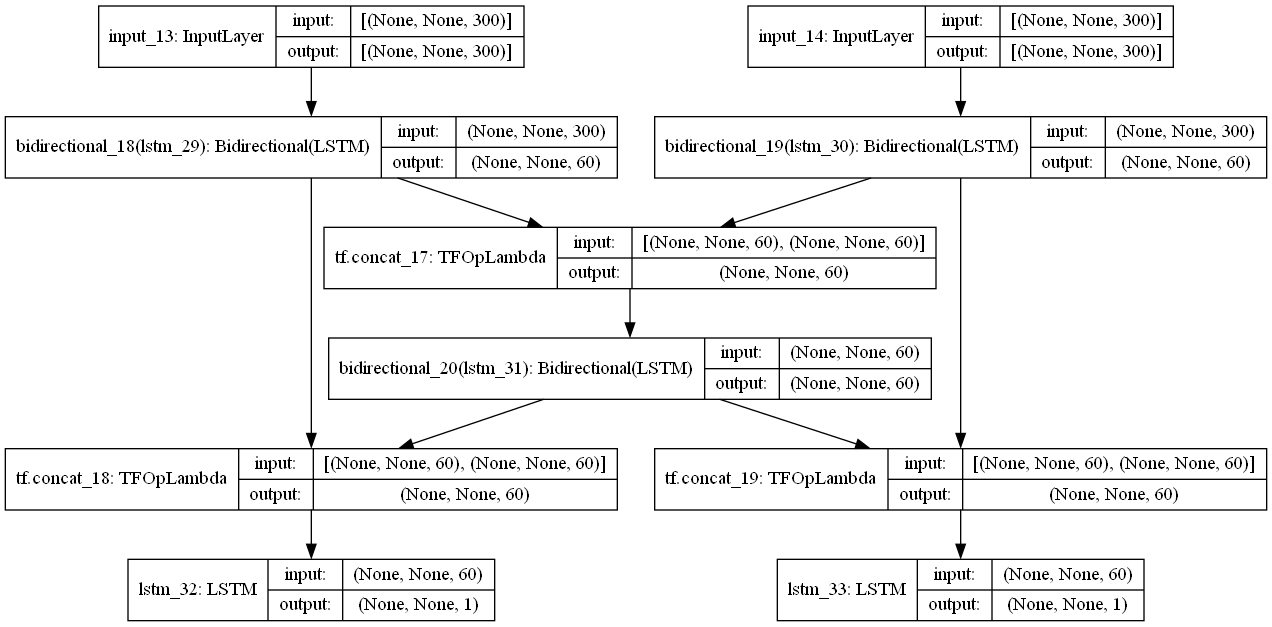

In [37]:
p1_in = layers.Input(shape=(None, 300), ragged=True)
p2_in = layers.Input(shape=(None, 300), ragged=True)
# cond_in = layers.Input(shape=(None,))

LSTM_p1 = layers.Bidirectional(layers.LSTM(30, return_sequences=True))(p1_in)
LSTM_p2 = layers.Bidirectional(layers.LSTM(30, return_sequences=True))(p2_in)
LSTM_concat = layers.Bidirectional(layers.LSTM(30, return_sequences=True))(tf.concat([LSTM_p1, LSTM_p2], axis=1))
'''
p2_cond_c = layers.Concatenate()([layers.Flatten()(LSTM_p2), cond_in])
all_c = layers.Concatenate()([layers.Flatten()(LSTM_p1), p2_cond_c])
'''
o_p1 = layers.LSTM(1, return_sequences=True)(tf.concat([LSTM_p1, LSTM_concat], axis=1))
o_p2 = layers.LSTM(1, return_sequences=True)(tf.concat([LSTM_p2, LSTM_concat], axis=1))
model = models.Model(inputs=[p1_in, p2_in], outputs=[o_p1, o_p2])
model.summary()
keras.utils.plot_model(model=model,
                       show_shapes=True)

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [4]:
Y = [tf.RaggedTensor.from_row_lengths(
    values=Y[0].merge_dims(0, 1).to_tensor(),
    row_lengths=[len(list(_)) for _ in Y[0]]),
    tf.RaggedTensor.from_row_lengths(
        values=Y[1].merge_dims(0, 1).to_tensor(),
        row_lengths=[len(list(_)) for _ in Y[1]])]
X = [
    tf.RaggedTensor.from_row_lengths(
        values=tf.ragged.constant(p1v).merge_dims(0, 1).to_tensor(),
        row_lengths=[len(_) for _ in p1v]),
    tf.RaggedTensor.from_row_lengths(
        values=tf.ragged.constant(p2v).merge_dims(0, 1).to_tensor(),
        row_lengths=[len(_) for _ in p2v]),
    tf.constant(cond)
]

AttributeError: 'list' object has no attribute 'shape'

In [26]:
'''
a1 = [_i.reshape(len(_i)) for _i in a1]
a2 = [_i.reshape(len(_i)) for _i in a2]
'''
a1 = [i.reshape(len(i), 1) for i in a1]
a2 = [i.reshape(len(i), 1) for i in a2]
print(a1[0].shape)
print(a2[0].shape)

(20, 1)
(2, 1)


In [42]:
model.fit(x=[X[0], X[1]], y=Y, epochs=1, verbose=1, batch_size=1)
model.summary()

C:\Users\Tom\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/lstm_32/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_5/lstm_32/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 60), dtype=float32), dense_shape=Tensor("gradient_tape/model_5/lstm_32/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\Tom\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/lstm_33/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_5/lstm_33/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 60), dtype=float32), 

InvalidArgumentError:  assertion failed: [Inputs must have identical ragged splits] [Condition x == y did not hold element-wise:] [x (RaggedFromVariant_2/RaggedTensorFromVariant:0) = ] [0 146] [y (model_5/lstm_32/RaggedFromTensor/concat:0) = ] [0 316]
	 [[{{node categorical_crossentropy/assert_equal_1/Assert/AssertGuard/else/_1625/categorical_crossentropy/assert_equal_1/Assert/AssertGuard/Assert}}]] [Op:__inference_train_function_27160126]

Function call stack:
train_function


In [32]:
Y[0] = tf.RaggedTensor.from_row_lengths(
    values=Y[0].merge_dims(0, 1).to_tensor(),
    row_lengths=[len(list(_)) for _ in Y[0]])
Y[1] = tf.RaggedTensor.from_row_lengths(
    values=Y[1].merge_dims(0, 1).to_tensor(),
    row_lengths=[len(list(_)) for _ in Y[1]])

In [34]:
print(Y[1].shape)

(7987, None, 1)
